In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Data preparation ###

In [2]:
# Load the CSV files
contacts = pd.read_csv("contacts.csv")
users = pd.read_csv("users.csv")
listings = pd.read_csv("listings.csv")

In [3]:
# Merge contacts with users for guest details
data = contacts.merge(users, left_on="id_guest_anon", right_on="id_user_anon", how="left")
data.rename(columns={"country": "country_guest", "words_in_user_profile": "words_in_guest_profile"}, inplace=True)

# Merge with users again for host details
data = data.merge(users, left_on="id_host_anon", right_on="id_user_anon", how="left", suffixes=("", "_host"))
data.rename(columns={"country": "country_host", "words_in_user_profile": "words_in_host_profile"}, inplace=True)

# Merge with listings
data = data.merge(listings, on="id_listing_anon", how="left")

In [4]:
# Select and reorder columns
columns = [
    "id_guest_anon", "country_guest", "words_in_guest_profile",
    "id_host_anon", "country_host", "words_in_host_profile",
    "id_listing_anon", "room_type", "listing_neighborhood", "total_reviews",
    "ts_interaction_first", "ts_reply_at_first", "ts_accepted_at_first", "ts_booking_at",
    "ds_checkin_first", "ds_checkout_first",
    "m_guests", "m_interactions", "m_first_message_length_in_characters",
    "contact_channel_first", "guest_user_stage_first"
]
data = data[columns]

# Save to data.csv
data.to_csv("data.csv", index=False)

### 4 ###

In [5]:
# Convert timestamps to datetime format
data["ts_booking_at"] = pd.to_datetime(data["ts_booking_at"])
data["ds_checkin_first"] = pd.to_datetime(data["ds_checkin_first"])

# Calculate lead time (in days) between booking and check-in
data["lead_time_days"] = (data["ds_checkin_first"] - data["ts_booking_at"]).dt.days

In [6]:
average_lead_time = data["lead_time_days"].mean()
print(f"Average lead time (in days): {average_lead_time:.2f}")

Average lead time (in days): 51.19


In [7]:
# 2. Booking time analysis by room type
room_type_analysis = data.groupby("room_type")["lead_time_days"].agg(["mean", "median"]).reset_index()
print("\nLead time by room type:")
print(room_type_analysis)


Lead time by room type:
         room_type       mean  median
0  Entire home/apt  53.792696    29.0
1     Private room  43.774333    18.0
2      Shared room  51.050761    33.0


In [8]:
# 3. Booking time analysis by listing neighborhood
neighborhood_analysis = data.groupby("listing_neighborhood")["lead_time_days"].agg(["mean", "median"]).reset_index()
print("\nLead time by listing neighborhood:")
print(neighborhood_analysis)


Lead time by listing neighborhood:
   listing_neighborhood       mean  median
0             -unknown-  54.273919    31.0
1              Abolição  73.000000    73.0
2               Andaraí  85.500000   107.0
3       Barra da Tijuca  60.275204    39.0
4          Barros Filho        NaN     NaN
..                  ...        ...     ...
63             Vaz Lobo        NaN     NaN
64              Vidigal  84.607143    69.5
65        Vigário Geral        NaN     NaN
66          Vila Isabel  45.937500    17.5
67        Vila da Penha        NaN     NaN

[68 rows x 3 columns]


In [9]:
# 4. Booking time analysis by total reviews (categorized)
# Categorize listings into buckets based on total reviews
data["review_category"] = pd.cut(
    data["total_reviews"],
    bins=[-1, 10, 50, 100, 500, float("inf")],
    labels=["0-10", "11-50", "51-100", "101-500", "500+"]
)
review_analysis = data.groupby("review_category")["lead_time_days"].agg(["mean", "median"]).reset_index()
print("\nLead time by review categories:")
print(review_analysis)


Lead time by review categories:
  review_category       mean  median
0            0-10  60.266993    39.0
1           11-50  42.437573    20.0
2          51-100  45.063739    25.0
3         101-500  43.478095    23.0
4            500+        NaN     NaN


/tmp/ipykernel_19721/1620090879.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_analysis = data.groupby("review_category")["lead_time_days"].agg(["mean", "median"]).reset_index()


### 5 ###

In [10]:
# Group by room_type and listing_neighborhood and count bookings
popular_neighborhoods = data.groupby(['room_type', 'listing_neighborhood']).size().reset_index(name='booking_count')

# Sort neighborhoods by booking count within each room type
popular_neighborhoods = popular_neighborhoods.sort_values(['room_type', 'booking_count'], ascending=[True, False])

# Display the top neighborhoods for each room type
top_neighborhoods = popular_neighborhoods.groupby('room_type').head(6)  # Top 5 neighborhoods per room type
print(top_neighborhoods)

           room_type listing_neighborhood  booking_count
0    Entire home/apt            -unknown-           8711
13   Entire home/apt           Copacabana           5569
25   Entire home/apt              Ipanema           2659
3    Entire home/apt      Barra da Tijuca            844
31   Entire home/apt               Leblon            840
7    Entire home/apt             Botafogo            516
55      Private room            -unknown-           2996
67      Private room           Copacabana           1059
79      Private room              Ipanema            400
100     Private room         Santa Teresa            284
60      Private room             Botafogo            240
73      Private room             Flamengo            198
111      Shared room            -unknown-            333
118      Shared room           Copacabana            104
138      Shared room         Santa Teresa             26
126      Shared room              Ipanema             21
114      Shared room           

In [11]:
# Calculate booking likelihood by number of guests
booking_likelihood = data.groupby('m_guests')['ts_booking_at'].apply(lambda x: x.notna().mean()).reset_index(name='booking_likelihood')

print(booking_likelihood)

    m_guests  booking_likelihood
0        0.0            0.500000
1        1.0            0.429968
2        2.0            0.473645
3        3.0            0.423432
4        4.0            0.352006
5        5.0            0.329854
6        6.0            0.251597
7        7.0            0.298592
8        8.0            0.207983
9        9.0            0.232558
10      10.0            0.178744
11      11.0            0.166667
12      12.0            0.152174
13      13.0            0.750000
14      14.0            0.375000
15      15.0            0.050000
16      16.0            0.055556


In [12]:
# Ensure columns are in datetime format
data['ds_checkin_first'] = pd.to_datetime(data['ds_checkin_first'], errors='coerce')
data['ds_checkout_first'] = pd.to_datetime(data['ds_checkout_first'], errors='coerce')

# Calculate stay duration in days
data['stay_duration'] = (data['ds_checkout_first'] - data['ds_checkin_first']).dt.days

# Group by number of guests and calculate patterns
checkin_checkout_patterns = data.groupby('m_guests').agg(
    avg_lead_time=('lead_time_days', 'mean'),
    avg_stay_duration=('stay_duration', 'mean'),
    median_stay_duration=('stay_duration', 'median')
).reset_index()

# Display the results
print(checkin_checkout_patterns)

    m_guests  avg_lead_time  avg_stay_duration  median_stay_duration
0        0.0      30.000000           1.500000                   1.5
1        1.0      36.333925          11.117000                   5.0
2        2.0      49.443964           6.562116                   4.0
3        3.0      52.822292           6.671287                   5.0
4        4.0      70.542144           6.256112                   5.0
5        5.0      65.185654           6.377175                   5.0
6        6.0      69.803175           6.888978                   5.0
7        7.0      71.669811           5.754930                   5.0
8        8.0      78.797980           6.214286                   5.0
9        9.0      92.150000           5.151163                   4.0
10      10.0      78.054054           6.937198                   5.0
11      11.0      51.400000           5.033333                   4.0
12      12.0     107.000000           6.500000                   4.0
13      13.0      66.000000       

### 6 ###

In [13]:
# Convert timestamps to datetime
data['ts_interaction_first'] = pd.to_datetime(data['ts_interaction_first'], errors='coerce')
data['ts_reply_at_first'] = pd.to_datetime(data['ts_reply_at_first'], errors='coerce')
data['ts_accepted_at_first'] = pd.to_datetime(data['ts_accepted_at_first'], errors='coerce')
data['ts_booking_at'] = pd.to_datetime(data['ts_booking_at'], errors='coerce')

# Calculate response time in hours
data['response_time_hours'] = (data['ts_reply_at_first'] - data['ts_interaction_first']).dt.total_seconds() / 3600

# Create acceptance and booking flags
data['is_accepted'] = ~data['ts_accepted_at_first'].isna()
data['is_booked'] = ~data['ts_booking_at'].isna()

In [14]:
# Group by total_reviews and calculate metrics
review_influence = data.groupby('total_reviews').agg(
    acceptance_rate=('is_accepted', 'mean'),
    booking_rate=('is_booked', 'mean'),
    avg_response_time=('response_time_hours', 'mean')
).reset_index()

# Calculate correlation between total_reviews and response time
correlation_reviews_response = data[['total_reviews', 'response_time_hours']].corr()

print("Review Influence Metrics:\n", review_influence)
print("\nCorrelation between total_reviews and response time:\n", correlation_reviews_response)

Review Influence Metrics:
      total_reviews  acceptance_rate  booking_rate  avg_response_time
0            -34.0         0.000000      0.000000           8.553681
1            -33.0         1.000000      1.000000           8.572500
2            -32.0         0.571429      0.428571           6.615480
3            -27.0         1.000000      1.000000          10.377361
4            -26.0         1.000000      1.000000           1.148056
..             ...              ...           ...                ...
167          174.0         0.625000      0.625000           9.428299
168          182.0         1.000000      0.903226           2.540648
169          185.0         0.750000      0.750000           4.191389
170          209.0         0.666667      0.666667           0.220556
171          268.0         1.000000      0.947368           0.281667

[172 rows x 4 columns]

Correlation between total_reviews and response time:
                      total_reviews  response_time_hours
total_revi

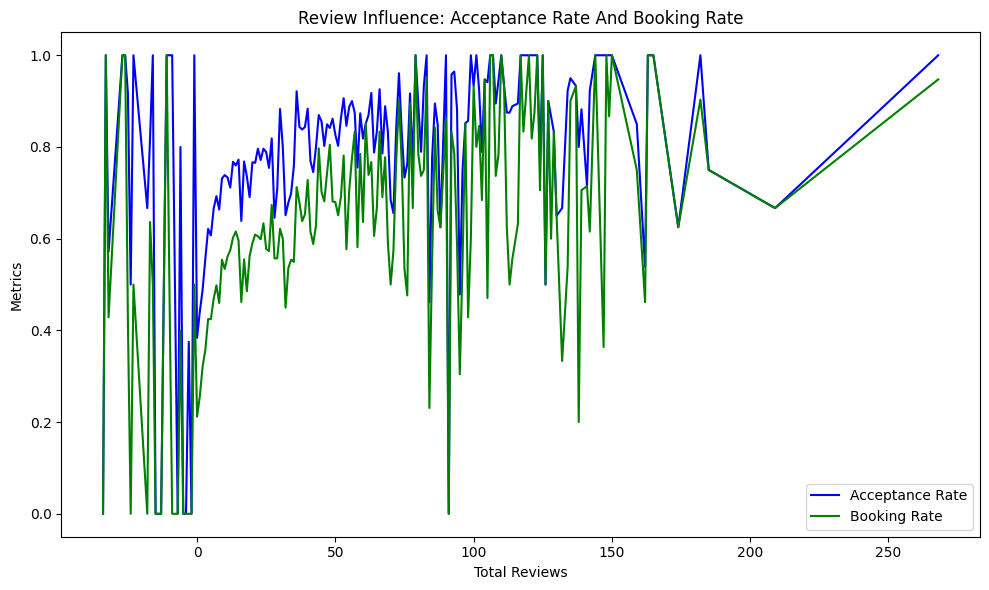

In [15]:
# Plotting all metrics on the same plot
plt.figure(figsize=(10, 6))

# Plot acceptance rate
plt.plot(review_influence['total_reviews'], review_influence['acceptance_rate'], label='Acceptance Rate', color='blue')

# Plot booking rate
plt.plot(review_influence['total_reviews'], review_influence['booking_rate'], label='Booking Rate', color='green')

# Adding labels and title
plt.title('Review Influence: Acceptance Rate And Booking Rate')
plt.xlabel('Total Reviews')
plt.ylabel('Metrics')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

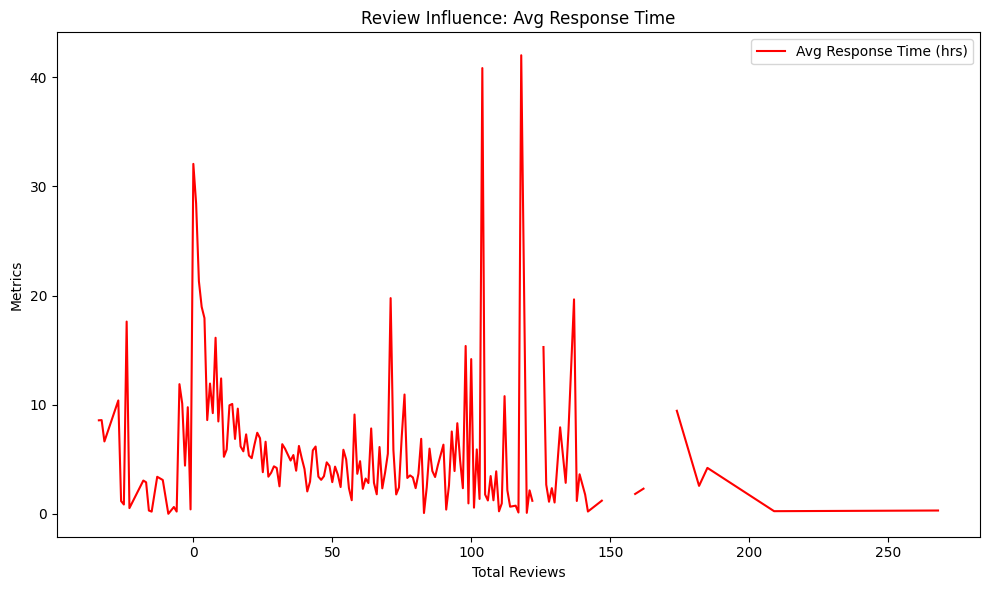

In [16]:
# Plotting all metrics on the same plot
plt.figure(figsize=(10, 6))

plt.plot(review_influence['total_reviews'], review_influence['avg_response_time'], label='Avg Response Time (hrs)', color='red')

# Adding labels and title
plt.title('Review Influence: Avg Response Time')
plt.xlabel('Total Reviews')
plt.ylabel('Metrics')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()